In [1]:
%config Completer.use_jedi = False

import glob
import os
import json
from itertools import product
import time
import pickle

import matplotlib.pyplot as plt
import trimesh
import numpy as np
import nibabel as nib

import neurodec as nd

nd.mdt._API_URL = "http://18.205.41.67:8001/"

nd.mdt.wait = False  # Set to true to wait step by step.

# Prepare model

Load MRI segmentation and labels information

In [2]:
DATA_DIR = '<your-data-path>/subject-01/'
nii = nib.load(DATA_DIR + 'MRI Segmentation.nii.gz')
image = nii.get_fdata()
voxel_sizes = np.array(nii.header.get_zooms()) * 1e-3 # from mm to m

with open(DATA_DIR + 'labels_description.json') as f:
    labels_description = json.load(f)

# Only these labels will be taken into account to build volume conductor
labels_per_tissue = {
    nd.mdt.TissueType.BONE: [ld['label_in_image'] for ld in labels_description['bones']],
    nd.mdt.TissueType.MUSCLE: [ld['label_in_image'] for ld in labels_description['muscles']],
    nd.mdt.TissueType.FAT: labels_description['fat']['label_in_image'],
    nd.mdt.TissueType.SKIN: labels_description['skin']['label_in_image'],
}

# Ignore marker labels when building volume conductor. Defining this list is optional,
# but it prevents warning messages when creating Image object 
labels_to_ignore = np.arange(23, 35)

Create image object

In [3]:
mri_image = nd.mdt.Image.new(image, voxel_sizes, labels_per_tissue, labels_to_ignore)

Create volume tetrahedral mesh from image

In [5]:
volume_mesh = nd.mdt.Tetrahedra.from_image(mri_image)

Create volume conductor

In [6]:
volume_conductor = nd.mdt.Conductor.new(volume_mesh)

Create electrode bracelet

In [7]:
outer_skin_surface = volume_mesh.skin
radius = 0.003  # in meters
first_electrode_location = np.array([0.048833, 0.039151, 0.225424])
rings_normal = np.array([-0.06736656677532368, 0.028649074948560272, -0.9973168885492202])
n_rings = 10
distance_between_rings = 0.009  # in meters
n_electrodes_per_ring = 16

bracelet = nd.mdt.ElectrodeBracelet.new(
    outer_skin_surface, radius, first_electrode_location, rings_normal,
    n_rings, distance_between_rings, n_electrodes_per_ring)

Generated electrodes can be saved as spheres for futher visualization

In [25]:
for i, electrode in enumerate(bracelet.electrodes):
    sphere = trimesh.creation.icosphere()
    sphere.vertices = sphere.vertices * electrode.radius
    sphere.vertices = sphere.vertices + electrode.location
    sphere.export(DATA_DIR + f'electrodes/elec_{i}.stl')

Create forward solution

In [8]:
forward_solution = nd.mdt.ForwardSolution.new(volume_conductor, bracelet.electrodes)

# Generate MUAPs for each muscle of interest

Store muscle surfaces extracted from volume mesh with respect to their label in image

In [24]:
surfaces = {}
for surface in volume_mesh.muscles:
    surfaces[surface.image_label] = surface

Generate fibers, motor units and MUAPs.

**Note, that we don't generate fibers for all the muscles in volume conductor**. Anconeus and Brachioradialis are not fully contained within the forearm segment and Supinator has too complex geometry to efficiently extract fibers with our current approach. For these muscles we don't provide tendon plane origins and normals in label description file.

In [12]:
SAMPLING_FREQUENCY = 4000
n_motor_units = 200

muscles_of_interest = []
muaps_per_muscle = []

for muscle in labels_description['muscles']:
    # We are only interested in muscles for which tendon planes are defined
    if 'plane_origins' in muscle:
        # Get muscle surface
        muscles_of_interest.append(muscle)
        muscle_surface = surfaces[muscle['label_in_image']]
        plane_origins = np.array(muscle['plane_origins'])
        plane_normals = np.array(muscle['plane_normals'])

        # Generate fibers
        fibers = nd.mdt.Fibers.new(muscle_surface, plane_origins, plane_normals)

        # Generate fiber basis
        fiber_basis = nd.mdt.FiberBasis.new(fibers, forward_solution)

        # Define fiber properties
        fiber_properties = nd.mdt.FiberProperties.new(fibers)

        # Generate motor units
        motor_units = nd.mdt.MotorUnits.new(fibers, n_motor_units)

        # Simulate corresponding muaps
        muaps = nd.mdt.MotorUnitsActionPotentials.new(fibers, fiber_basis, fiber_properties, motor_units,
                                                      SAMPLING_FREQUENCY)
        muaps_per_muscle.append(muaps)

# Simulate simple movement

In [14]:
def single_muscle_activation(max_mvc, duration, peak_time, fs):
    n_time_samples = int((peak_time + duration / 2.) * fs)
    t = np.linspace(-np.pi / 2, np.pi + np.pi / 2, int(duration * fs))
    waveform = max_mvc * 0.5 * (np.sin(t) + 1.)
    i_0 = n_time_samples - len(waveform)
    muscle_activation = np.zeros(n_time_samples)
    muscle_activation[i_0:] = waveform
    return muscle_activation

def generate_movement(n_muscles, mean_max_mvc, std_max_mvc, duration, peak_time, fs):
    muscle_activations = []
    for i in range(n_muscles):
        max_mvc = np.random.uniform(mean_max_mvc - std_max_mvc,
                                    mean_max_mvc + std_max_mvc)
        max_mvc = np.clip(max_mvc, 0., 100.)
        muscle_activations.append(single_muscle_activation(max_mvc, duration, peak_time, fs))
    return muscle_activations

Print labels of the muscles of interest

In [15]:
for i, muscle in enumerate(muscles_of_interest):
    print(i, muscle['label'])

0 Extensor Carpi Ulnaris
1 Flexor Digitorium Profundus
2 Flexor Carpi Ulnaris
3 Extensor Digitorium
4 Extensor Digiti Minimi
5 Extersor Carpi radialis Longus AND Brevis
6 Palmaris Longus
7 Flexor Carpi Radialis
8 Flexor Digitorium Superficialis
9 Abductor Pollicis Longus
10 Extensor Indicis
11 Extensor Pollicis Longus
12 Pronator Teres
13 Flexor Policis Longus
14 Pronator Quadratus


Select wrist extensors

In [16]:
muscle_idx = [0, 5]

Generate a simple 2 second long muscle activation patern corresponding to a wrist extension of around 40%MVC at its peak.

In [17]:
np.random.seed(1)
n_muscles = len(muscle_idx)
mean_max_mvc = 40 # %MVC
std_max_mvc = 10 # add some inter muscle variability in %MVC
duration = 2. # sec
peak_time = 1.5 # sec
activations = generate_movement(n_muscles, mean_max_mvc, std_max_mvc, duration, peak_time, SAMPLING_FREQUENCY)

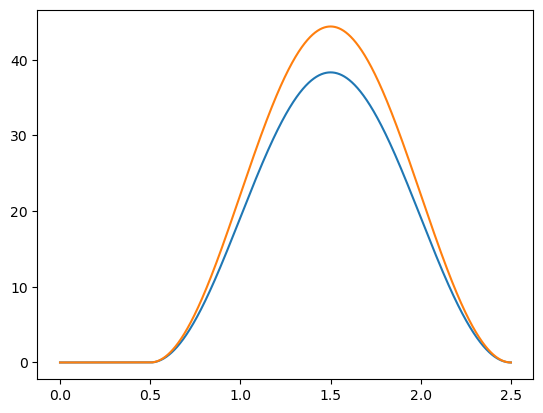

In [18]:
for single_activation in activations:
    times = np.arange(len(single_activation)) / SAMPLING_FREQUENCY
    plt.plot(times, single_activation)

Generate impulse trains for each active muscle

In [19]:
impulse_trains_per_muscle = []
for muscle_id, single_activation in zip(muscle_idx, activations):
    impulse_trains_per_muscle.append(nd.mdt.ImpulseTrains.new(muaps_per_muscle[muscle_id],
                                                              single_activation,
                                                              random_seed=0))

Assemble raw sEMG signal from muaps and impulse trains, and load the resulting data.

In [20]:
emg_per_muscle = []
for impulse_trains in impulse_trains_per_muscle:
    emg = nd.mdt.Electromyography.new(impulse_trains)
    emg.wait() # wait for the computation to finish before loading the EMG data
    emg_per_muscle.append(emg.data.copy())

Sum up EMG signals of individual muscles

In [21]:
min_length = np.min([e.shape[1] for e in emg_per_muscle])
emg_total = np.sum([e[:, :min_length] for e in emg_per_muscle], axis=0)

Plot the results

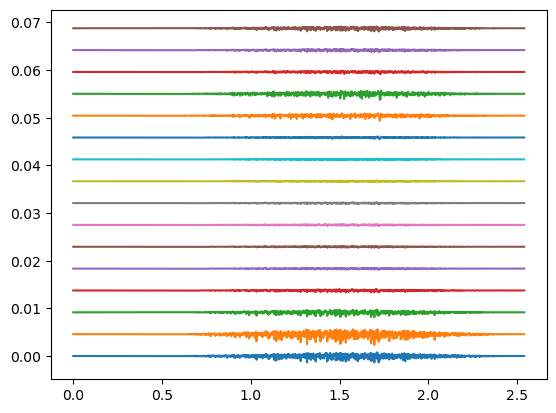

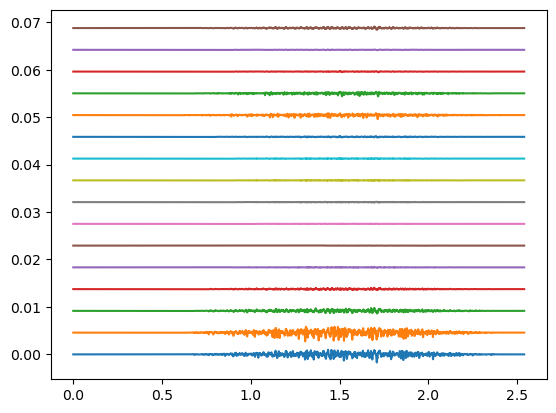

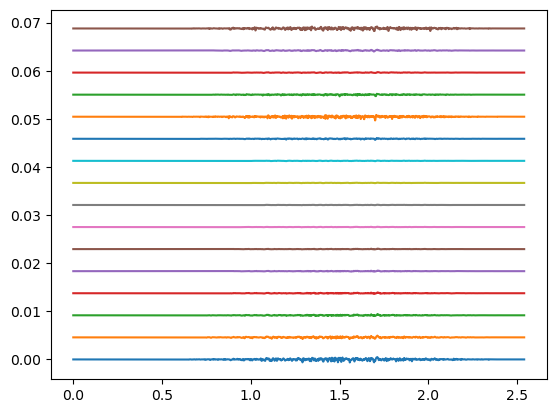

In [22]:
times = np.arange(emg_total.shape[1]) / SAMPLING_FREQUENCY
plot_shift = np.ptp(emg_total)
rings_to_plot = [0, 4, 9]

for ring in rings_to_plot:
    emg_to_plot = emg_total[ring*16:(ring+1)*16]
    plt.figure()
    plt.plot(times, emg_to_plot.T + plot_shift * np.arange(16))
    plt.show()